In [3]:
from dataset_helpers import *
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np 
import faiss
import time
import joblib
import csv
import subprocess
from configs import *

### Flicker-8k dataset

In [5]:
data = dataset(src_path=DATASET_PATH, feature_path=FEATURE_PATH)
data.get_file_name()
data.preprocess_dataset(entire_dataset=False)
# data.load_dataset()
print("Features: ", data.features)

In [3]:
query = "two people"
best_images = data.search_query(query, num_matches=10)
print("Length of features: ", len(data.features))
print("Best images: ", best_images)

Length of features:  8091
Best images:  [(0.2883, 8018), (0.2834, 5003), (0.2815, 844), (0.2798, 299), (0.2747, 7635), (0.2734, 125), (0.2727, 1396), (0.2712, 6869), (0.2703, 2844), (0.2698, 4334)]


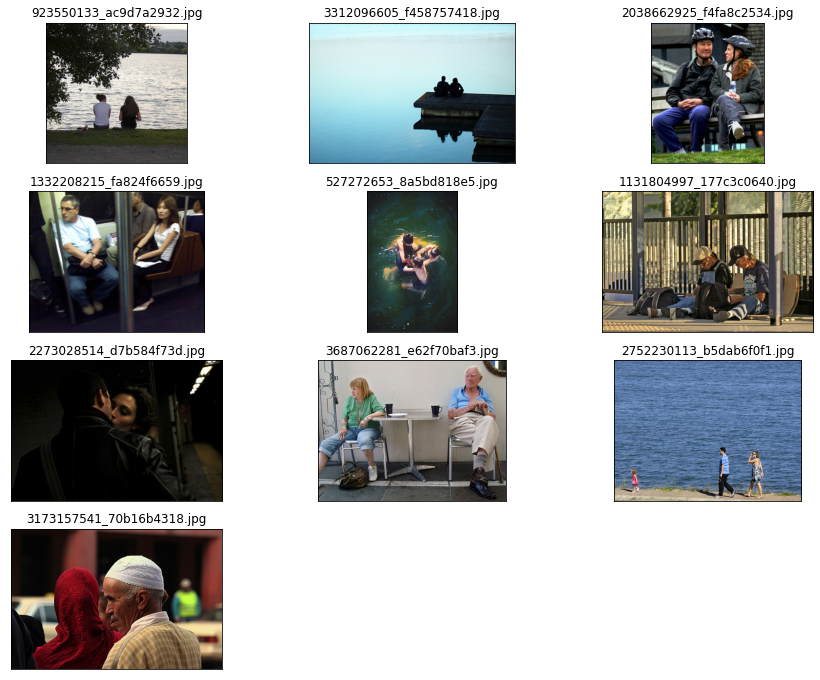

In [7]:
data.display_results(best_images)

### CLIP model for V3C dataset

In [5]:
# Whether you wanna generate new features
generate_features = True

print("Dataset name: ", DATASET_NAME)
clip = CLIPSearchEngine(src_path=DATASET_MASTER_PATH, feature_path=FEATURE_PATH, generate_features=generate_features)
# clip.dataset.get_file_name()

Dataset name:  V3C


In [7]:
clip.dataset.get_file_name()
# clip.load_features()
# print("Features: ", len(clip.features))

Loading all image names ...


In [9]:
clip.load_features()

Loading feature files ...


100%|██████████| 156757/156757 [07:25<00:00, 352.17it/s]


In [10]:
len(clip.dataset.image_names)

2508110

In [11]:
query = 'people standing on the beach'
# query = clip.dataset.image_names[1000]

Time:  0.6009786128997803
Length of features:  2508110
Can't find best matched images.


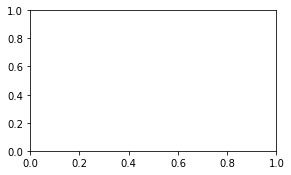

In [14]:
begin = time.time()
best_images = clip.search_query(query, num_matches=1000, ss_type='other')
# best_images = clip.search_query(query, num_matches=100, nlist=10, ss_type='faiss')
end = time.time()
print("Time: ", end - begin)
print("Length of features: ", len(clip.features))
display_results(best_images[:15])
# print("Best images: ", best_images)

In [1]:
# display_results(best_images[15:30])

### Debug

#### Test faiss

Implement faiss algorithm for vector similarity search. After computing features, we will use faiss instead of Cosine similarity (the goal is to check whether it is faster or not).

In [10]:
clip.load_features()
print("Features: ", len(clip.features))

Loading feature files ...


100%|██████████| 156757/156757 [01:45<00:00, 1489.51it/s]


Features:  2508110


In [12]:
query = "snow mountain"
text_encoded = clip.clip_model.encode_text_query(query)
    
# Retrieve the description vector and the image vectors
text_features = text_encoded.cpu().numpy().astype('float32')

In [70]:
quantiser = faiss.IndexFlatL2(dimension)  
index = faiss.IndexIVFFlat(quantiser, dimension, nlist, faiss.METRIC_L2)

In [71]:
print(index.is_trained)   # False
index.train(features)  # train on the database vectors
print(index.ntotal)   # 0
index.add(features)   # add the vectors and update the index
print(index.is_trained)  # True
print(index.ntotal)   # 200

False
0
True
467488


#### Find similar images

In [52]:
query = clip.dataset.image_names[1000]

In [54]:
img_query = convert_to_concepts(query, dataset_name=DATASET_NAME)['filename']
feature = clip.feature_dict[img_query]
feature_vec = np.expand_dims(feature, axis=0)
feature_vector = feature_vec.astype('float32')

In [55]:
similarities = (feature_vector @ clip.features.T).squeeze(0)
indices = similarities.argsort()[-50:][::-1]
best_matched_image_names = [clip.dataset.image_names[item] for item in indices]

result = [convert_to_concepts(item, dataset_name=clip.dataset_name) for item in best_matched_image_names]

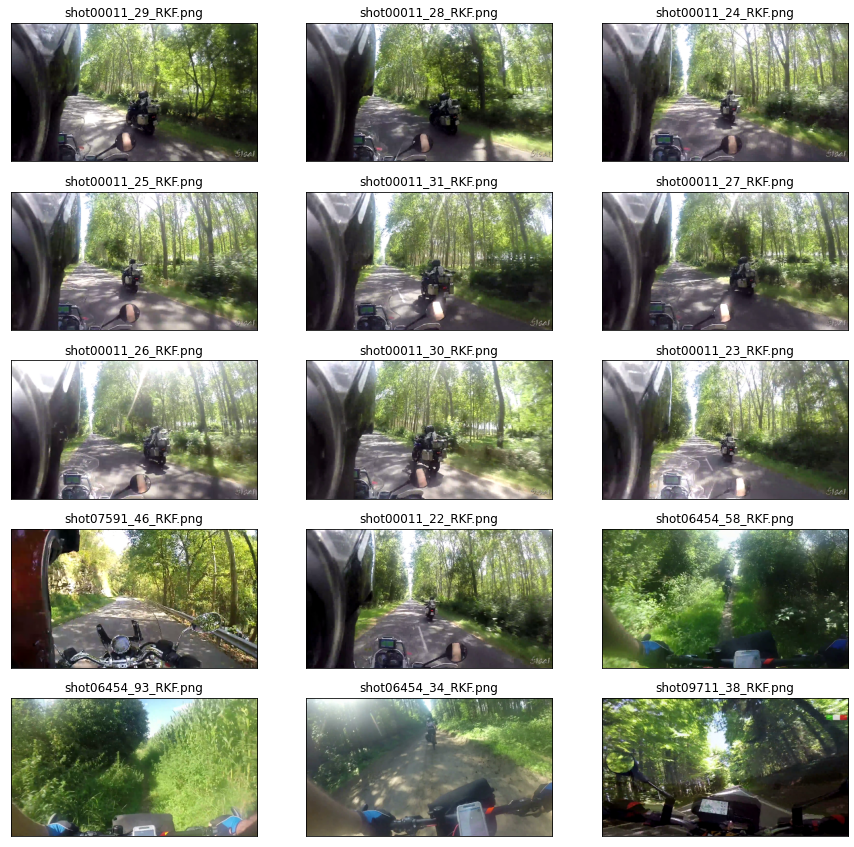

In [56]:
display_results(result[:15])

## Preprocess data

### Resize keyframes

In [2]:
resized_path = osp.join(DATASET_MASTER_PATH, 'resized_keyframes')
original_path = osp.join(DATASET_MASTER_PATH, 'keyframes/extract/00001')
filename_list = os.listdir(original_path)
img_path = filename_list[0]
img_path = osp.join(original_path, img_path)
output = resize_image(filename, 25)
len(filename_list)

### Split keyframes to subfolders

In [2]:
# folder_name = 'test_folder'
# path = osp.join('/home/ntnhu/projects/VideoFall-VBS2022/results/', folder_name)
# if not osp.isdir(path):
#     os.mkdir(path)
# subprocess.call(f"mv /home/ntnhu/projects/VideoFall-VBS2022/results/xxx/* {path}", shell=True)


In [7]:
V3C2_path = '/mnt/SEAGATE/root/V3C2/keyframes/'
V3C2_videos = sort_list(os.listdir(V3C2_path))
V3C2_keyframes = sort_list(glob(osp.join(V3C2_path, '*/*.png')))
keyframe_path = '/mnt/DEAKIN/VBS2022/resized_keyframes/*.png'
keyframes = sort_list(glob(keyframe_path))

In [26]:
for kf in tqdm(keyframes[10000:100000]):
    video_name = kf.split('/')[-1][4:9]
    video_path = osp.join('/mnt/DEAKIN/VBS2022/keyframes/', video_name)
    if not osp.isdir(video_path):
        os.mkdir(video_path)
#     print(kf)
    subprocess.call(f"mv {kf} {video_path}", shell=True)

100%|██████████| 90000/90000 [40:34<00:00, 36.97it/s]  


In [24]:
# max_len = 17235
# for idx in range(1, 5):
#     video_name = f'{idx:05d}'
#     video_path = osp.join('/mnt/DEAKIN/VBS2022/keyframes/', video_name)
#     if not osp.isdir(video_path):
#         os.mkdir(video_path)
#     for kf in tqdm(keyframes[:1000]):
#         if f'shot{video_name}' in kf:
# #             print(kf)
#             subprocess.call(f"cp {kf} {video_path}", shell=True)
    

### Load and Save image names

In [4]:
# Whether you wanna generate new features
generate_features = True

print("Dataset name: ", DATASET_NAME)
clip = CLIPSearchEngine(src_path=DATASET_PATH, feature_path=FEATURE_PATH, generate_features=generate_features)
clip.dataset.get_file_name()

Dataset name:  V3C
Loading all image names ...


In [8]:
# image_name_path = '/mnt/DEAKIN/VBS2022/metadata'
# filename = osp.join(image_name_path, 'image_names.joblib')
# csv_filename = osp.join(image_name_path, 'image_names.csv')
# # joblib.dump(clip.dataset.image_names, filename)
# with open(csv_filename, 'w') as f:
#     # create the csv writer
#     writer = csv.writer(f, delimiter='\n')
#     writer.writerow(clip.dataset.image_names)

#### Count number of keyframes per video

In [32]:
keyframe_dict = {}
folder_names = sort_list(os.listdir(DATASET_PATH))
for folder in tqdm(folder_names[:10]):
    folder_path = osp.join(DATASET_PATH, folder)
    filenames = sort_list(os.listdir(folder_path))
    keyframe_dict[folder] = len(filenames)

100%|██████████| 10/10 [00:00<00:00, 219.18it/s]


In [33]:
keyframe_dict

{'00001': 114,
 '00002': 75,
 '00003': 217,
 '00004': 58,
 '00005': 101,
 '00006': 90,
 '00007': 100,
 '00008': 136,
 '00009': 16,
 '00010': 65}